In [1]:
import torch
print("Cuda_available? ", torch.cuda.is_available())
print("Name: ", torch.cuda.get_device_name(0))
print("Device count: ", torch.cuda.device_count())
print("current device: ", torch.cuda.current_device())
print("Select device: ", torch.cuda.device(0))
print("get device name: ",torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #finally got the solution

Cuda_available?  True
Name:  NVIDIA RTX A6000
Device count:  1
current device:  0
Select device:  <torch.cuda.device object at 0x7efcec47edd0>
get device name:  NVIDIA RTX A6000


In [2]:
data_dir = 'data2/'

In [3]:
import os
import glob
images_pt = sorted(glob.glob(os.path.join(data_dir, 'PETCT*', '*', "SUV*")))
images_ct = sorted(glob.glob(os.path.join(data_dir, 'PETCT*', '*', "CTres*")))
images_sg = sorted(glob.glob(os.path.join(data_dir, 'PETCT*', '*', "SEG*")))
data_dicts = [
            {"image_pt": image_name_pt, "image_ct": image_name_ct, "image_sg": image_name_sg}
            for image_name_pt, image_name_ct, image_name_sg in zip(images_pt, images_ct, images_sg)
        ]
keys = ["image_pt", "image_ct", "image_sg"]
train_files, val_files = data_dicts[:70], data_dicts[70:]

In [4]:
data_dicts

[{'image_pt': 'data2/PETCT_07b7e9abfc/02-10-2003-NA-PET-CT Ganzkoerper nativ-08717/SUV.nii.gz',
  'image_ct': 'data2/PETCT_07b7e9abfc/02-10-2003-NA-PET-CT Ganzkoerper nativ-08717/CTres.nii.gz',
  'image_sg': 'data2/PETCT_07b7e9abfc/02-10-2003-NA-PET-CT Ganzkoerper nativ-08717/SEG.nii.gz'},
 {'image_pt': 'data2/PETCT_07fec0d985/05-04-2006-NA-PET-CT Ganzkoerper  primaer mit KM-11312/SUV.nii.gz',
  'image_ct': 'data2/PETCT_07fec0d985/05-04-2006-NA-PET-CT Ganzkoerper  primaer mit KM-11312/CTres.nii.gz',
  'image_sg': 'data2/PETCT_07fec0d985/05-04-2006-NA-PET-CT Ganzkoerper  primaer mit KM-11312/SEG.nii.gz'},
 {'image_pt': 'data2/PETCT_080922db5a/01-28-2006-NA-PET-CT Teilkoerper  primaer mit KM-83609/SUV.nii.gz',
  'image_ct': 'data2/PETCT_080922db5a/01-28-2006-NA-PET-CT Teilkoerper  primaer mit KM-83609/CTres.nii.gz',
  'image_sg': 'data2/PETCT_080922db5a/01-28-2006-NA-PET-CT Teilkoerper  primaer mit KM-83609/SEG.nii.gz'},
 {'image_pt': 'data2/PETCT_08198c4f0c/11-10-2005-NA-PET-CT Ganzkoer

In [5]:
from monai.transforms import (
Compose,
LoadImaged,
EnsureChannelFirstd,
Spacingd,
Orientationd,
ScaleIntensityRanged,
CropForegroundd,
ConcatItemsd,
DivisiblePadd,
AddChanneld,
RandCropByPosNegLabeld,
RandFlipd,EnsureTyped,
RandRotate90d,
RandShiftIntensityd,
Resized
)

In [6]:
crop_val = 96
train_transforms = Compose(
    [
        LoadImaged(keys=keys),
        AddChanneld(keys=keys),
        ScaleIntensityRanged(
            keys=["image_ct"], a_min=-100, a_max=250,
             b_min=0.0, b_max=1.0, clip=True,
        ),
        ScaleIntensityRanged(
            keys=["image_pt"], a_min=0, a_max=15,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        #CropForegroundd(keys=["image_ct", "image_pt"], source_key="image_ct"),
        Orientationd(keys=keys, axcodes="LAS"),
        # Resized(keys=keys, spatial_size=(256, 256, 256)), # resizing all keys
        ConcatItemsd(keys=["image_pt", "image_ct"], name="image_petct", dim=0),
        # Add some augmentations
        RandCropByPosNegLabeld(keys=["image_petct", "image_sg"], label_key="image_sg", spatial_size=(crop_val, crop_val, crop_val), pos=1, neg=1,
            num_samples=6,
            image_key="image_petct",
            image_threshold=0,
        ),
        RandRotate90d(
            keys=["image_petct", "image_sg"],
            prob=0.10,
            max_k=3,
        ),
        RandFlipd(
            keys=["image_petct", "image_sg"],
            spatial_axis=[0, 1, 2],
            prob=0.10,
        ),
        RandShiftIntensityd(
            keys=["image_petct"],
            offsets=0.10,
            prob=0.50,
        ),
        EnsureTyped(keys=["image_petct", "image_sg"]),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
<class 'monai.transforms.utility.dictionary.AddChanneld'>: Class `AddChanneld` has been deprecated since version 0.8. It will be removed in version 1.3. please use MetaTensor data type and monai.transforms.EnsureChannelFirstd instead with `channel_dim='no_channel'`.
monai.transforms.utility.dictionary EnsureChannelFirstd.__init__:meta_keys: Argument `meta_keys` has been deprecated since version 0.9. not needed if image is type `MetaTensor`.


In [7]:
val_transforms = Compose(
    [
        LoadImaged(keys=keys),
        AddChanneld(keys=keys),
        ScaleIntensityRanged(
            keys=["image_ct"], a_min=-100, a_max=250,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        ScaleIntensityRanged(
            keys=["image_pt"], a_min=0, a_max=15,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        #CropForegroundd(keys=["image_ct", "image_pt"], source_key="image_ct"),
        Orientationd(keys=keys, axcodes="LAS"),
        # Resized(keys=keys, spatial_size=(256, 256, 256)), # resizing all keys
        ConcatItemsd(keys=["image_pt", "image_ct"], name="image_petct", dim=0),
        EnsureTyped(keys=["image_petct", "image_sg"]),
    ]
)


In [8]:
import glob
import os
import nibabel as nib
from monai.data import CacheDataset,    Dataset,    DataLoader,    decollate_batch
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.transforms import AsDiscrete
from monai.inferers import sliding_window_inference
from monai.transforms import Resize
import numpy as np
from monai.networks.nets import SwinUNETR, VNet

In [9]:
#train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.03)
train_ds = Dataset(data=train_files, transform=train_transforms)
#val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=0.05)
val_ds = Dataset(data=val_files, transform=val_transforms)

In [13]:
# Create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = VNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=1,
    act='elu',
    dropout_dim=3,
    bias=False
).to(device)

loss_function = DiceLoss(to_onehot_y=2, softmax=True)
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr)
dice_metric = DiceMetric(include_background=True, reduction="mean")

In [14]:
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader  = DataLoader(val_ds, batch_size=1, shuffle=True, num_workers=0)

In [15]:
#tranformation check
for batch_data in train_loader:
      label = batch_data["image_sg"]
      label = label != 0
        #print('The label values: ', np.unique(label))
      print(label.shape)

      inputs, labels = (
         batch_data["image_petct"].to(device),
         label.to(device),
      )
      print(inputs.shape)
      print(labels.shape)
      break

torch.Size([6, 1, 96, 96, 96])
torch.Size([6, 2, 96, 96, 96])
torch.Size([6, 1, 96, 96, 96])


In [16]:
max_epochs = 50
val_interval = 1
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])
checkpoint_path = os.path.join(data_dir, "checkpoint.pth")

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_metric = checkpoint['best_metric']
    best_metric_epoch = checkpoint['best_metric_epoch']
    epoch_loss_values = checkpoint['epoch_loss_values']
    metric_values = checkpoint['metric_values']
else:
    start_epoch = 0

for epoch in range(start_epoch,max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image_petct"].to(device),
            batch_data["image_sg"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    if epoch % 7 == 0 :
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_metric': best_metric,
            'best_metric_epoch': best_metric_epoch,
            'epoch_loss_values': epoch_loss_values,
            'metric_values': metric_values
        }, checkpoint_path)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image_petct"].to(device),
                    val_data["image_sg"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(data_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/50


single channel prediction, `softmax=True` ignored.
single channel prediction, `to_onehot_y=True` ignored.


1/70, train_loss: 0.9532
2/70, train_loss: 0.9174
3/70, train_loss: 0.9450
4/70, train_loss: 1.0000
5/70, train_loss: 0.9873
6/70, train_loss: 0.9536
7/70, train_loss: 0.6584
8/70, train_loss: 0.5728
9/70, train_loss: 0.8322
10/70, train_loss: 0.9251
11/70, train_loss: 0.9571
12/70, train_loss: 0.8786
13/70, train_loss: 0.6194
14/70, train_loss: 0.9992
15/70, train_loss: 0.9156
16/70, train_loss: 0.9293
17/70, train_loss: 0.9999
18/70, train_loss: 0.9927
19/70, train_loss: 0.8697
20/70, train_loss: 0.3838
21/70, train_loss: 0.9960
22/70, train_loss: 0.9059
23/70, train_loss: 0.6405


Num foregrounds 0, Num backgrounds 28768152, unable to generate class balanced samples, setting `pos_ratio` to 0.


24/70, train_loss: 1.0000
25/70, train_loss: 0.9581
26/70, train_loss: 0.9827
27/70, train_loss: 0.9945
28/70, train_loss: 0.2466
29/70, train_loss: 0.9800
30/70, train_loss: 1.0030


Num foregrounds 0, Num backgrounds 37525656, unable to generate class balanced samples, setting `pos_ratio` to 0.


31/70, train_loss: 1.0000
32/70, train_loss: 0.9998


Num foregrounds 0, Num backgrounds 27049912, unable to generate class balanced samples, setting `pos_ratio` to 0.


33/70, train_loss: 1.0000
34/70, train_loss: 0.9950
35/70, train_loss: 0.8235
36/70, train_loss: 0.8698
37/70, train_loss: 0.9627
38/70, train_loss: 1.1427
39/70, train_loss: 1.0646
40/70, train_loss: 1.0266
41/70, train_loss: 0.9991
42/70, train_loss: 0.9758
43/70, train_loss: 0.9902
44/70, train_loss: 1.0000
45/70, train_loss: 0.9956
46/70, train_loss: 0.9975
47/70, train_loss: 0.9994
48/70, train_loss: 0.9988
49/70, train_loss: 0.9997
50/70, train_loss: 0.9961


Num foregrounds 0, Num backgrounds 21754744, unable to generate class balanced samples, setting `pos_ratio` to 0.


51/70, train_loss: 1.0000
52/70, train_loss: 1.0000
53/70, train_loss: 0.9989


Num foregrounds 0, Num backgrounds 24254224, unable to generate class balanced samples, setting `pos_ratio` to 0.


54/70, train_loss: 1.0000
55/70, train_loss: 0.9996
56/70, train_loss: 0.9998
57/70, train_loss: 1.0000
58/70, train_loss: 0.9990
59/70, train_loss: 0.9735
60/70, train_loss: 0.8533
61/70, train_loss: 0.9904
62/70, train_loss: 0.9866
63/70, train_loss: 0.9620
64/70, train_loss: 0.9899
65/70, train_loss: 0.9420
66/70, train_loss: 0.9932
67/70, train_loss: 0.9997
68/70, train_loss: 1.0109
69/70, train_loss: 0.9950
70/70, train_loss: 0.9890
epoch 1 average loss: 0.9360
saved new best metric model
current epoch: 1 current mean dice: 0.4999
best mean dice: 0.4999 at epoch: 1
----------
epoch 2/50
1/70, train_loss: 0.9878
2/70, train_loss: 0.9748
3/70, train_loss: 0.9999
4/70, train_loss: 0.9991
5/70, train_loss: 0.9999
6/70, train_loss: 0.9947
7/70, train_loss: 0.9783
8/70, train_loss: 0.9999
9/70, train_loss: 0.9932
10/70, train_loss: 1.0000
11/70, train_loss: 0.9207
12/70, train_loss: 0.9918
13/70, train_loss: 1.0271
14/70, train_loss: 0.9997
15/70, train_loss: 1.0051
16/70, train_loss: 1

In [17]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.4999 at epoch: 1


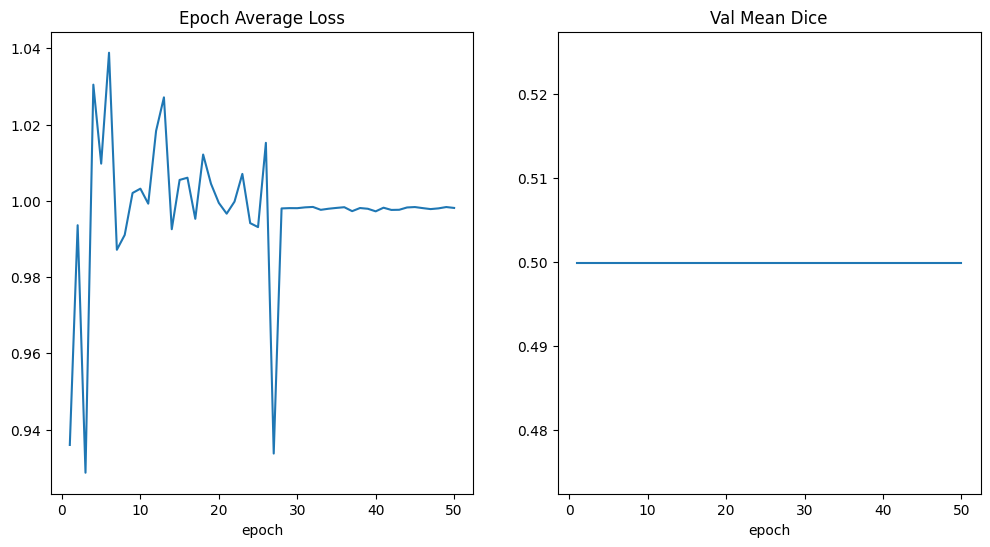

In [18]:
import matplotlib.pyplot as plt

plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

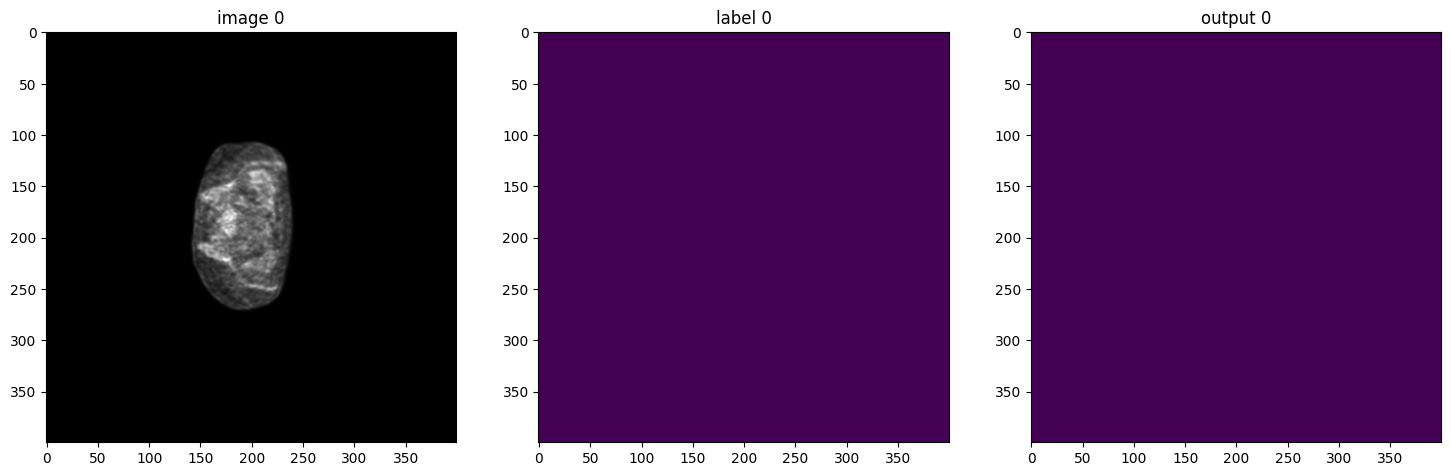

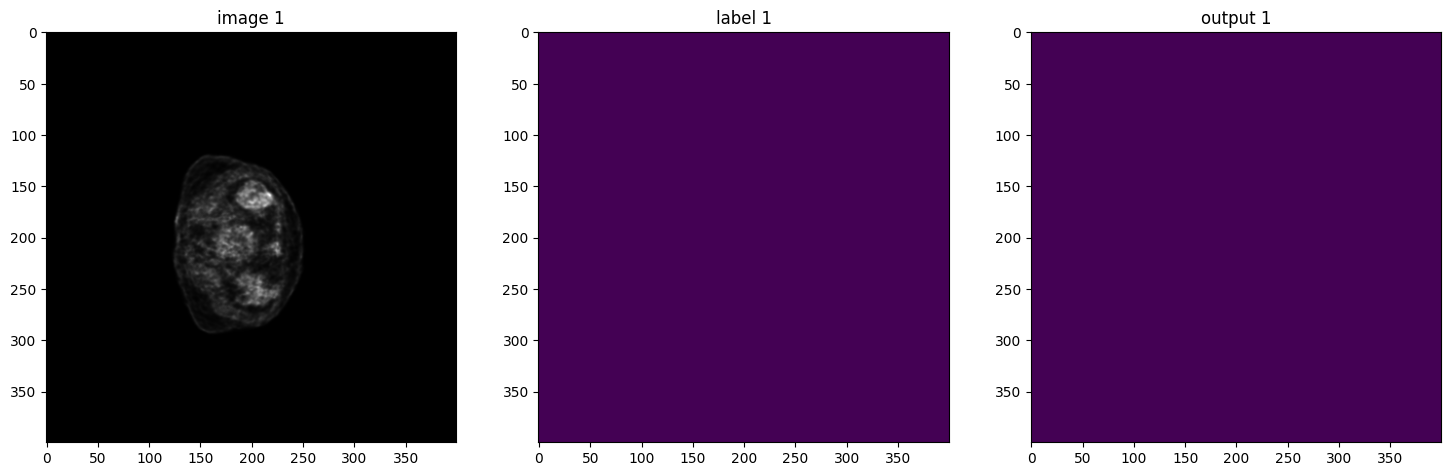

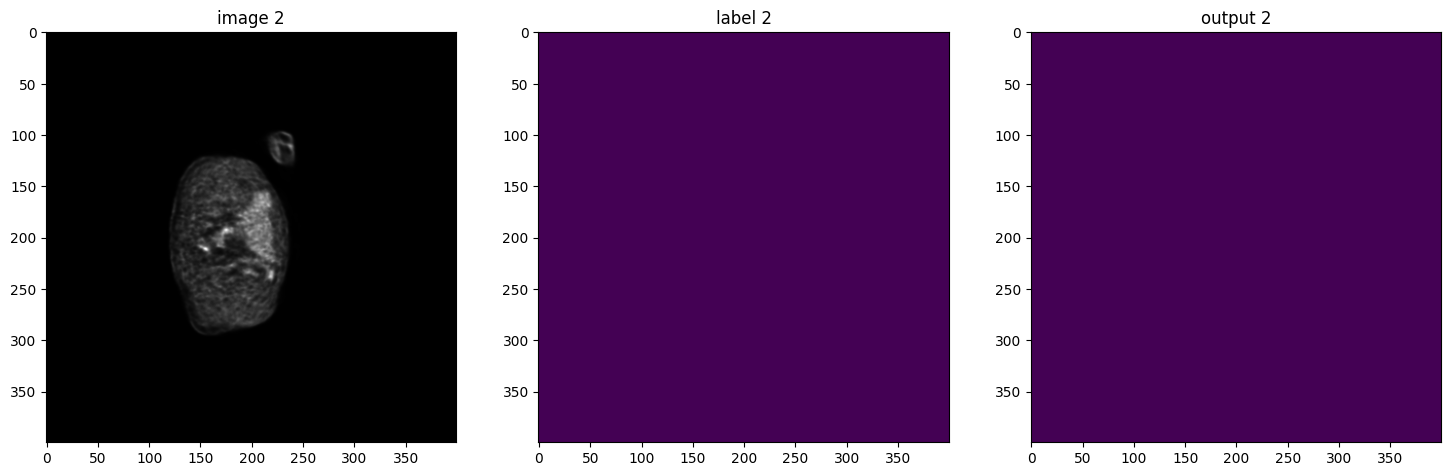

In [19]:
model.load_state_dict(torch.load(os.path.join(data_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image_petct"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image_petct"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["image_sg"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break